In [3]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [4]:
dataroot = "../abstract_1/small_abstract"
n_dl_thrds = 3
batch_size = 128
image_size = 128
#num channels = number of color components per pixel
nc = 3
# size of input latent vector
nz = 100
# feature map size for generator
ngf = 32
# feature map size for discriminator
ndf = 32
num_epochs = 500
# learning rate
lr = 0.0003
# see Adam's optimizers for more 
beta1 = 0.5
beta2 = 0.999
# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

noise_level = 0.1

In [5]:
class gen(nn.Module):
    def __init__(self, ngpu):
        super(gen, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(nz, ngf * 16, 4, 1, 0, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 16),

            # state size. (ngf*16) x 4 x 4
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 16, ngf * 8, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 8),

            # state size. (ngf*8) x 8 x 8
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 4),
            # state size. (ngf*4) x 16 x 16 
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf * 2),
            # state size. (ngf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False)),
            nn.LeakyReLU(0.2, True),
            nn.BatchNorm2d(ngf),
            # state size. (ngf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.ConvTranspose2d(    ngf,      nc, 4, 2, 1, bias=False)),
            nn.Tanh()
            # state size. (nc) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

class disc(nn.Module):
    def __init__(self, ngpu):
        super(disc, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            torch.nn.utils.spectral_norm(nn.Conv2d(nc, ndf, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf, ndf * 2, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 2),
            
            # state size. (ndf*2) x 32 x 32
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 2, ndf * 4, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 4),
            
            # state size. (ndf*4) x 16 x 16 
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 4, ndf * 8, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 8),
            
            # state size. (ndf*8) x 8 x 8
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 8, ndf * 16, 4, stride=2, padding=1, bias=False)),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(ndf * 16),
            
            # state size. (ndf*16) x 4 x 4
            torch.nn.utils.spectral_norm(nn.Conv2d(ndf * 16, 1, 4, stride=1, padding=0, bias=False)),
            nn.Sigmoid()
            # state size. 1
        )
    def forward(self, input):
        return self.main(input)

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
#returns generator network only for now
def train_GAN(device, dataloader):
    netG = gen(ngpu).to(device)
    if ((device.type == 'cuda') and (ngpu > 1)):
        netG = nn.DataParallel(netG, list(range(ngpu)))
    netG.apply(weights_init)
    print(netG)
    netD = disc(ngpu).to(device)
    if ((device.type == 'cuda') and (ngpu > 1)):
        netD = nn.DataParallel(netD, list(range(ngpu)))
    netD.apply(weights_init)
    print(netD)
    criterion = nn.BCELoss()
    fixed_noise = torch.randn(128, nz, 1, 1, device=device)
    real_label = 1.
    fake_label = 0.
    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, beta2))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, beta2))
    img_list = []
    img_list_2 = []
    G_losses = []
    D_losses = []
    iters = 0
    for epoch in range(num_epochs):
        for i, data in enumerate(dataloader, 0):
            #Update discriminator
            #training it with a batch from training set
            netD.zero_grad()
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0)
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            #pass batch of real images
            output = netD(real_cpu).view(-1)
            #calculate loss
            errD_real = criterion(output, label)
            #calculate gradients
            errD_real.backward()
            D_x = output.mean().item()

            #train discriminator with output from generator
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            #generates batch of fake images
            fake = netG(noise)
            label.fill_(fake_label)
            #classify the generated images
            output = netD(fake.detach()).view(-1)
            #discriminators loss on generated images
            errD_fake = criterion(output, label)
            #gradients for discriminator and sum with gradients from real batch
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            errD = errD_real + errD_fake
            #updates disc
            optimizerD.step()

            #Update generator
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            #forward pass fake images again through discriminator
            output = netD(fake).view(-1)
            #calculates gen loss on disc pass
            errG = criterion(output, label)
            #gradients for gen
            errG.backward()
            D_G_z2 = output.mean().item()
            #update generator
            optimizerG.step()
            if i % 8 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())
            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 25 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                vutils.save_image(vutils.make_grid(fake[0], padding=2, normalize=True), 'nnimages_prog_2/'+str(iters)+'image' + str(random.random()) + '.jpg')
            iters += 1
    torch.save({
        'netG_state_dict': netG.state_dict(),
        'netD_state_dict': netD.state_dict(),
        'optimizerG_state_dict': optimizerG.state_dict(),
        'optimizerD_state_dict': optimizerD.state_dict()
        }, 'model_1000.tar')
    return netG

In [7]:
def run():
    dataset = dset.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(image_size),
                                   transforms.CenterCrop(image_size),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                             shuffle=True, num_workers=n_dl_thrds)
    dataloader_2 = torch.utils.data.DataLoader(dataset, batch_size=32,
                                             shuffle=True, num_workers=n_dl_thrds)
    device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
    real_batch = next(iter(dataloader_2))
    plt.figure(figsize=(16,16))
    plt.axis("off")
    plt.title("Training Images")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:128], padding=2, normalize=True).cpu(),(1,2,0)))
    plt.show()
    generator = train_GAN(device, dataloader)
    torch.save(generator.state_dict(), 'gen_1_1000.pt')
    for i in range(128):
        noise = torch.randn(128, nz, 1, 1, device=device)
        nn_img = generator(noise).detach().cpu()
        vutils.save_image(vutils.make_grid(nn_img[0], padding=2, normalize=True), 'nnimages_2/z_'+str(i)+'image' + str(random.random()) + '.jpg')

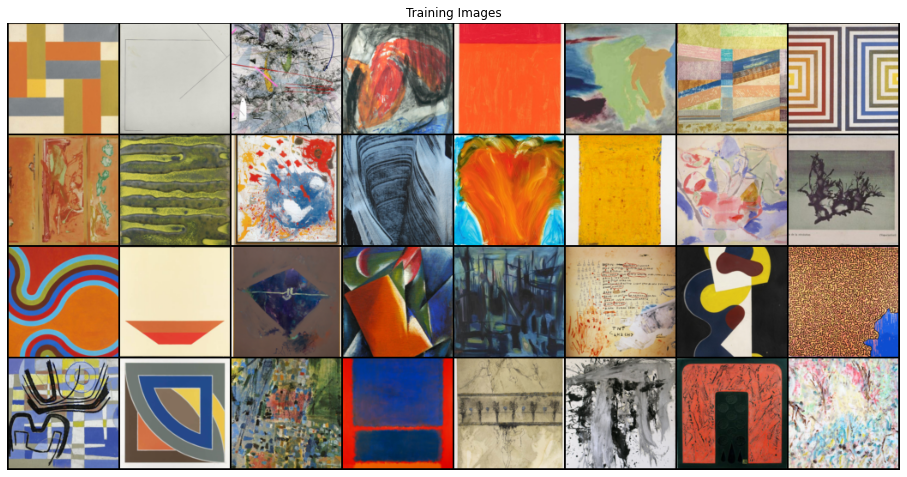

gen(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ConvTransp

[22/400][16/17]	Loss_D: 0.0000	Loss_G: 51.0529	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/400][0/17]	Loss_D: 0.0000	Loss_G: 51.8151	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/400][8/17]	Loss_D: 0.0000	Loss_G: 51.5549	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[23/400][16/17]	Loss_D: 0.0000	Loss_G: 53.5530	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/400][0/17]	Loss_D: 0.0000	Loss_G: 52.1777	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/400][8/17]	Loss_D: 0.0000	Loss_G: 52.4899	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[24/400][16/17]	Loss_D: 0.0002	Loss_G: 52.2599	D(x): 0.9998	D(G(z)): 0.0000 / 0.0000
[25/400][0/17]	Loss_D: 0.0000	Loss_G: 52.1481	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/400][8/17]	Loss_D: 0.0000	Loss_G: 53.1057	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[25/400][16/17]	Loss_D: 0.0000	Loss_G: 53.1571	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[26/400][0/17]	Loss_D: 0.0001	Loss_G: 52.3656	D(x): 0.9999	D(G(z)): 0.0000 / 0.0000
[26/400][8/17]	Loss_D: 0.0000	Loss_G: 52.0409	D(x): 1.0000	D(G(z)): 0.00

[55/400][8/17]	Loss_D: 0.0000	Loss_G: 50.9373	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[55/400][16/17]	Loss_D: 0.0000	Loss_G: 51.5787	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[56/400][0/17]	Loss_D: 0.0000	Loss_G: 51.1742	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[56/400][8/17]	Loss_D: 0.0000	Loss_G: 52.0108	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[56/400][16/17]	Loss_D: 0.0000	Loss_G: 51.8739	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[57/400][0/17]	Loss_D: 0.0000	Loss_G: 52.7009	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[57/400][8/17]	Loss_D: 0.0000	Loss_G: 51.8279	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[57/400][16/17]	Loss_D: 0.0000	Loss_G: 52.1176	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[58/400][0/17]	Loss_D: 0.0000	Loss_G: 51.2159	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[58/400][8/17]	Loss_D: 0.0000	Loss_G: 51.9492	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[58/400][16/17]	Loss_D: 0.0000	Loss_G: 52.9702	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[59/400][0/17]	Loss_D: 0.0000	Loss_G: 51.9366	D(x): 1.0000	D(G(z)): 0.00

[88/400][0/17]	Loss_D: 0.0000	Loss_G: 51.4807	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[88/400][8/17]	Loss_D: 0.0000	Loss_G: 51.0739	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[88/400][16/17]	Loss_D: 0.0000	Loss_G: 51.3545	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[89/400][0/17]	Loss_D: 0.0000	Loss_G: 51.1181	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[89/400][8/17]	Loss_D: 0.0000	Loss_G: 51.0585	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[89/400][16/17]	Loss_D: 0.0000	Loss_G: 50.5806	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[90/400][0/17]	Loss_D: 0.0000	Loss_G: 51.3679	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[90/400][8/17]	Loss_D: 0.0000	Loss_G: 50.8234	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[90/400][16/17]	Loss_D: 0.0000	Loss_G: 50.1946	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[91/400][0/17]	Loss_D: 0.0000	Loss_G: 51.0442	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[91/400][8/17]	Loss_D: 0.0000	Loss_G: 51.2152	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[91/400][16/17]	Loss_D: 0.0000	Loss_G: 51.7269	D(x): 1.0000	D(G(z)): 0.00

[120/400][8/17]	Loss_D: 0.0000	Loss_G: 51.3726	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[120/400][16/17]	Loss_D: 0.0000	Loss_G: 51.7761	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[121/400][0/17]	Loss_D: 0.0000	Loss_G: 51.7161	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[121/400][8/17]	Loss_D: 0.0000	Loss_G: 50.6336	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[121/400][16/17]	Loss_D: 0.0000	Loss_G: 52.5498	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[122/400][0/17]	Loss_D: 0.0000	Loss_G: 51.2820	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[122/400][8/17]	Loss_D: 0.0000	Loss_G: 50.9950	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[122/400][16/17]	Loss_D: 0.0000	Loss_G: 54.5270	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[123/400][0/17]	Loss_D: 0.0000	Loss_G: 49.9908	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[123/400][8/17]	Loss_D: 0.0000	Loss_G: 50.2294	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[123/400][16/17]	Loss_D: 0.0000	Loss_G: 51.7219	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[124/400][0/17]	Loss_D: 0.0000	Loss_G: 51.0305	D(x): 1.0000	D

[152/400][16/17]	Loss_D: 0.0000	Loss_G: 49.3239	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[153/400][0/17]	Loss_D: 0.0000	Loss_G: 51.8700	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[153/400][8/17]	Loss_D: 0.0000	Loss_G: 51.2540	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[153/400][16/17]	Loss_D: 0.0000	Loss_G: 50.0772	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[154/400][0/17]	Loss_D: 0.0000	Loss_G: 52.0155	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[154/400][8/17]	Loss_D: 0.0000	Loss_G: 51.3647	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[154/400][16/17]	Loss_D: 0.0000	Loss_G: 49.9614	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[155/400][0/17]	Loss_D: 0.0000	Loss_G: 50.9959	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[155/400][8/17]	Loss_D: 0.0000	Loss_G: 50.9570	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[155/400][16/17]	Loss_D: 0.0000	Loss_G: 52.3400	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[156/400][0/17]	Loss_D: 0.0000	Loss_G: 51.6061	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[156/400][8/17]	Loss_D: 0.0000	Loss_G: 51.8132	D(x): 1.0000	D

[185/400][0/17]	Loss_D: 0.0000	Loss_G: 51.3387	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[185/400][8/17]	Loss_D: 0.0000	Loss_G: 51.4204	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[185/400][16/17]	Loss_D: 0.0000	Loss_G: 49.9591	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[186/400][0/17]	Loss_D: 0.0000	Loss_G: 51.5980	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[186/400][8/17]	Loss_D: 0.0000	Loss_G: 50.7861	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[186/400][16/17]	Loss_D: 0.0000	Loss_G: 51.1560	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[187/400][0/17]	Loss_D: 0.0000	Loss_G: 51.5740	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[187/400][8/17]	Loss_D: 0.0000	Loss_G: 50.8463	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[187/400][16/17]	Loss_D: 0.0000	Loss_G: 50.2906	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[188/400][0/17]	Loss_D: 0.0000	Loss_G: 52.2950	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[188/400][8/17]	Loss_D: 0.0000	Loss_G: 50.3473	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[188/400][16/17]	Loss_D: 0.0000	Loss_G: 51.2606	D(x): 1.0000	D

[217/400][8/17]	Loss_D: 0.0000	Loss_G: 50.9941	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[217/400][16/17]	Loss_D: 0.0000	Loss_G: 52.0139	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[218/400][0/17]	Loss_D: 0.0000	Loss_G: 49.9827	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[218/400][8/17]	Loss_D: 0.0000	Loss_G: 51.2899	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[218/400][16/17]	Loss_D: 0.0000	Loss_G: 52.0033	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[219/400][0/17]	Loss_D: 0.0000	Loss_G: 51.3733	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[219/400][8/17]	Loss_D: 0.0000	Loss_G: 51.2018	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[219/400][16/17]	Loss_D: 0.0000	Loss_G: 51.7187	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[220/400][0/17]	Loss_D: 0.0000	Loss_G: 50.0114	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[220/400][8/17]	Loss_D: 0.0000	Loss_G: 50.5481	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[220/400][16/17]	Loss_D: 0.0000	Loss_G: 51.1818	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[221/400][0/17]	Loss_D: 0.0000	Loss_G: 50.3618	D(x): 1.0000	D

[249/400][16/17]	Loss_D: 0.0000	Loss_G: 51.0562	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[250/400][0/17]	Loss_D: 0.0000	Loss_G: 51.2304	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[250/400][8/17]	Loss_D: 0.0000	Loss_G: 51.0824	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[250/400][16/17]	Loss_D: 0.0000	Loss_G: 51.5473	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[251/400][0/17]	Loss_D: 0.0000	Loss_G: 50.9510	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[251/400][8/17]	Loss_D: 0.0000	Loss_G: 51.6033	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[251/400][16/17]	Loss_D: 0.0000	Loss_G: 51.0961	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[252/400][0/17]	Loss_D: 0.0000	Loss_G: 51.5528	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[252/400][8/17]	Loss_D: 0.0000	Loss_G: 51.6138	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[252/400][16/17]	Loss_D: 0.0000	Loss_G: 52.3611	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[253/400][0/17]	Loss_D: 0.0000	Loss_G: 50.5266	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[253/400][8/17]	Loss_D: 0.0000	Loss_G: 50.1560	D(x): 1.0000	D

[282/400][0/17]	Loss_D: 0.0000	Loss_G: 50.6221	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[282/400][8/17]	Loss_D: 0.0000	Loss_G: 51.6704	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[282/400][16/17]	Loss_D: 0.0000	Loss_G: 53.0425	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[283/400][0/17]	Loss_D: 0.0000	Loss_G: 50.6199	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[283/400][8/17]	Loss_D: 0.0000	Loss_G: 50.7829	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[283/400][16/17]	Loss_D: 0.0000	Loss_G: 51.4333	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[284/400][0/17]	Loss_D: 0.0000	Loss_G: 50.8073	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[284/400][8/17]	Loss_D: 0.0000	Loss_G: 51.1715	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[284/400][16/17]	Loss_D: 0.0000	Loss_G: 51.6009	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[285/400][0/17]	Loss_D: 0.0000	Loss_G: 50.6990	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[285/400][8/17]	Loss_D: 0.0000	Loss_G: 50.7050	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[285/400][16/17]	Loss_D: 0.0000	Loss_G: 50.8091	D(x): 1.0000	D

[314/400][8/17]	Loss_D: 0.0000	Loss_G: 49.6059	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[314/400][16/17]	Loss_D: 0.0000	Loss_G: 50.1184	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[315/400][0/17]	Loss_D: 0.0000	Loss_G: 50.7397	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[315/400][8/17]	Loss_D: 0.0000	Loss_G: 50.7101	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[315/400][16/17]	Loss_D: 0.0000	Loss_G: 52.1727	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[316/400][0/17]	Loss_D: 0.0000	Loss_G: 50.8195	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[316/400][8/17]	Loss_D: 0.0000	Loss_G: 50.3289	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[316/400][16/17]	Loss_D: 0.0000	Loss_G: 51.6353	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[317/400][0/17]	Loss_D: 0.0000	Loss_G: 51.1725	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[317/400][8/17]	Loss_D: 0.0000	Loss_G: 51.3270	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[317/400][16/17]	Loss_D: 0.0000	Loss_G: 50.6818	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[318/400][0/17]	Loss_D: 0.0000	Loss_G: 50.8825	D(x): 1.0000	D

[346/400][16/17]	Loss_D: 0.0000	Loss_G: 49.9050	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[347/400][0/17]	Loss_D: 0.0000	Loss_G: 50.3986	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[347/400][8/17]	Loss_D: 0.0000	Loss_G: 50.5652	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[347/400][16/17]	Loss_D: 0.0000	Loss_G: 51.9137	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[348/400][0/17]	Loss_D: 0.0000	Loss_G: 51.1892	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[348/400][8/17]	Loss_D: 0.0000	Loss_G: 51.4174	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[348/400][16/17]	Loss_D: 0.0000	Loss_G: 51.4008	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[349/400][0/17]	Loss_D: 0.0000	Loss_G: 51.0017	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[349/400][8/17]	Loss_D: 0.0000	Loss_G: 50.7373	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[349/400][16/17]	Loss_D: 0.0000	Loss_G: 51.3321	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[350/400][0/17]	Loss_D: 0.0000	Loss_G: 50.6777	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[350/400][8/17]	Loss_D: 0.0000	Loss_G: 50.7738	D(x): 1.0000	D

In [ ]:
if __name__ == '__main__':
    run()

In [30]:
torch.cuda.empty_cache() 